<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:45px;">
  <div style="color:#993520; font-size:54px; font-weight:bold; margin-bottom:10px;">
    SENTIMENT ANALYSIS OF U.S. SENATORS' TWEETS
  </div>
  <div style="color:#333; font-size:22px; margin-top:10px;">
    TF-IDF + Logistic Regression + GridSearchCV + political communication insights (May–Oct 2020)
      </div>
    Performed by: Zahra Eshtiaghi 476679 Under Supervision of Dr. Maciej Świtała
  </div>
</div>


### 1. Intro (what this notebook does)

**Topic.** This notebook applies a classical supervised sentiment model to the same U.S. senators’ tweet dataset (May–Oct 2020) to complement the dictionary-based baseline.

**Why TF-IDF + Logistic Regression?** TF-IDF features with Logistic Regression are a strong, well-understood baseline for text classification. They are fast to train, easy to tune, and offer some interpretability (important n-grams / coefficients).

**Important labeling note (silver labels).**
The original dataset does not contain human sentiment labels. To train a supervised model, I use **silver labels** generated by the Transformer model (see the Transformers notebook). This means the Logistic Regression model is trained to *approximate* the Transformer’s labeling behavior, not true ground-truth sentiment.

**Project objective (clear & measurable).**
1) build a supervised 3-class sentiment classifier (Negative/Neutral/Positive),
2) **optimize hyperparameters** with cross-validated GridSearchCV,
3) evaluate on a held-out test split of the silver-labeled data,
4) apply the best model to all tweets and analyze sentiment patterns (party/time/engagement).

**What you will see in this notebook.**
- Cleaning + vectorization (TF-IDF) and a Logistic Regression classifier in a pipeline
- Hyperparameter tuning with GridSearchCV (ngram range, min/max df, sublinear TF, C, class weights)
- Test evaluation (classification report + confusion matrix)
- Full-corpus predictions and analysis similar to the dictionary/transformer notebooks
- Short conclusion + limitations (label quality, class imbalance, domain language)


In [11]:
# !pip -q install pandas numpy scikit-learn joblib matplotlib tqdm vaderSentiment

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

RANDOM_STATE = 42
plt.rcParams["figure.dpi"] = 120


### Loading dataset (target / unlabeled)

In [2]:
SENATORS_PATH = "/Users/majid/Documents/3-third semester/text mining /project/senator sentiment/senator_twitter_May-Oct.csv"  # change if needed

df = pd.read_csv(SENATORS_PATH)
df = df.drop(columns=[c for c in df.columns if c.lower().startswith("unnamed")], errors="ignore")

df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)

for col in ["likes", "retweets", "replies"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

print(df.shape)
display(df.head(3))


(30490, 15)


,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,1322145371108331520,2020-10-30 11:56:35+00:00,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,1321926867696390144,2020-10-29 21:28:20+00:00,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,1321906471244845061,2020-10-29 20:07:17+00:00,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


### Text cleaning function

In [3]:
def clean_text_basic(text: str) -> str:
    text = str(text)

    # normalize mentions + URLs
    text = re.sub(r"@\w+", "@user", text)
    text = re.sub(r"http\S+|www\.\S+", "http", text)

    # remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text_clean"] = df["text"].astype(str).apply(clean_text_basic)


### Geting labeled training data from Transfomer Sentiment labaled dataset 
>Because the dataset has no human sentiment labels, I used Transformer predictions as pseudo-labels to train a supervised baseline (TF-IDF + Logistic Regression). Therefore, evaluation reflects agreement with the Transformer model rather than true ground-truth sentiment.

In [8]:
LABELED_TRAIN_PATH = "/Users/majid/Documents/3-third semester/text mining /senator_tweets_with_sentiment.csv"  # <-- put your labeled file here


# def make_vader_labels(text_series: pd.Series) -> pd.Series:
#     analyzer = SentimentIntensityAnalyzer()
#     comp = text_series.astype(str).apply(lambda t: analyzer.polarity_scores(t)["compound"])
#     # 3-class standard thresholds
#     def lab(x):
#         if x >= 0.05:
#             return "Positive"
#         elif x <= -0.05:
#             return "Negative"
#         else:
#             return "Neutral"
#     return comp.apply(lab)

# if os.path.exists(LABELED_TRAIN_PATH):
#     train_df = pd.read_csv(LABELED_TRAIN_PATH)
#     if "text" not in train_df.columns or "label" not in train_df.columns:
#         raise ValueError("Your labeled file must have columns: text, label")

#     train_df["text_clean"] = train_df["text"].astype(str).apply(clean_text_basic)

#     # normalize labels to strings
#     # supports numeric 0/1/2 or strings
#     if pd.api.types.is_numeric_dtype(train_df["sent_label"]):
#         # assume 0=Negative, 1=Neutral, 2=Positive (common)
#         id2lab = {0: "Negative", 1: "Neutral", 2: "Positive"}
#         train_df["label_str"] = train_df["label"].map(id2lab)
#     else:
#         train_df["label_str"] = (
#             train_df["label"].astype(str).str.strip().str.capitalize()
#         )

#     print("Using external labeled dataset:", LABELED_TRAIN_PATH)


train_df = pd.read_csv(LABELED_TRAIN_PATH)

print("Columns in file:", train_df.columns.tolist())

# ---- choose the correct columns from your file ----
TEXT_COL = "text"
LABEL_COL = "sent_label"   # <-- this is your transformer label column

if TEXT_COL not in train_df.columns:
    raise ValueError(f"Missing text column '{TEXT_COL}'. Available: {train_df.columns.tolist()}")

if LABEL_COL not in train_df.columns:
    raise ValueError(f"Missing label column '{LABEL_COL}'. Available: {train_df.columns.tolist()}")

# clean text
train_df["text_clean"] = train_df[TEXT_COL].astype(str).apply(clean_text_basic)

# normalize label strings
train_df["label_str"] = (
    train_df[LABEL_COL]
      .astype(str)
      .str.strip()
      .str.capitalize()
)

# keep only valid labels
valid = {"Negative","Neutral","Positive"}
train_df = train_df[train_df["label_str"].isin(valid)].copy()

print("Training label distribution:")
print(train_df["label_str"].value_counts())
display(train_df[["text_clean","label_str"]].head())


Columns in file: ['tweet_id', 'time', 'text', 'replies', 'retweets', 'likes', 'from_user', 'from_content', 'twitter_id', 'name', 'state', 'party', 'gender', 'age', 'text_clean', 'date', 'month', 'sent_label', 'sent_conf', 'p_neg', 'p_neu', 'p_pos', 'log_likes', 'log_retweets', 'log_replies', 'sent_score']
Training label distribution:
label_str
Neutral     15058
Positive    12196
Negative     3106
Name: count, dtype: int64


,text_clean,label_str
0,More jobs. More investment. More economic oppo...,Positive
1,Marty and I are excited to be back on the camp...,Positive
2,ICYMI: Gov. Kemp announces 46 people snared in...,Negative
3,I promised that Georgia would stop and dismant...,Positive
4,"Now or on November 3rd, vote for the political...",Neutral


### Train/test split (for evaluation)

In [9]:
X = train_df["text_clean"].values
y = train_df["label_str"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 24288 Test: 6072


### Pipeline + GridSearchCV (hyperparameter optimization)

In [ ]:
# pipe = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("clf", LogisticRegression(
#         max_iter=3000,
#         solver="saga",          # good for large sparse data
#         multi_class="auto",
#         n_jobs=-1,
#         random_state=RANDOM_STATE
#     ))
# ])

# param_grid = {
#     # TF-IDF options
#     "tfidf__ngram_range": [(1,1), (1,2)],
#     "tfidf__min_df": [1, 2, 5],
#     "tfidf__max_df": [0.9, 0.95, 1.0],
#     "tfidf__sublinear_tf": [True, False],

#     # Logistic Regression options
#     "clf__C": [0.1, 0.5, 1, 2, 5],
#     "clf__penalty": ["l2"],
#     "clf__class_weight": [None, "balanced"]
# }

# grid = GridSearchCV(
#     pipe,
#     param_grid=param_grid,
#     scoring="f1_macro",   # good for class imbalance
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# grid.fit(X_train, y_train)

# print("Best CV f1_macro:", grid.best_score_)
# print("Best params:")
# for k, v in grid.best_params_.items():
#     print(f"  {k}: {v}")


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: Futur

KeyboardInterrupt: 

In [12]:


# a subset for grid search (faster)
SUBSET_SIZE = 8000  # 5000–12000
sss = StratifiedShuffleSplit(n_splits=1, train_size=SUBSET_SIZE, random_state=RANDOM_STATE)

idx_train, _ = next(sss.split(X_train, y_train))
X_tune = X_train[idx_train]
y_tune = y_train[idx_train]

print("Tuning subset:", len(X_tune))

grid_fast = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,            # reducing folds from 5 to 3
    n_jobs=-1,
    verbose=1 
)

grid_fast.fit(X_tune, y_tune)

print("Best CV f1_macro:", grid_fast.best_score_)
print("Best params:", grid_fast.best_params_)

best_model = grid_fast.best_estimator_

# Refit best model on FULL training data
best_model.fit(X_train, y_train)


Tuning subset: 8000
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: Futur

Best CV f1_macro: 0.7269302551325083
Best params: {'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


### Evaluate on holdout test set (correctness section)


Classification report (test):
              precision    recall  f1-score   support

    Negative      0.618     0.723     0.667       621
     Neutral      0.853     0.812     0.832      3012
    Positive      0.840     0.854     0.847      2439

    accuracy                          0.819      6072
   macro avg      0.770     0.796     0.782      6072
weighted avg      0.824     0.819     0.821      6072



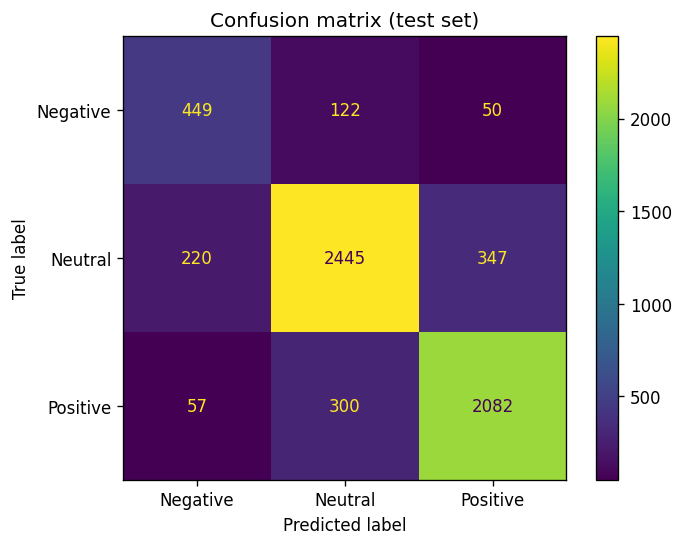

In [14]:
best_model = grid_fast.best_estimator_

y_pred = best_model.predict(X_test)

print("\nClassification report (test):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred, labels=["Negative","Neutral","Positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Neutral","Positive"])
disp.plot()
plt.title("Confusion matrix (test set)")
plt.show()


### Train final model on all labeled data + apply to senators tweets

In [15]:
best_model.fit(X, y)

# Predict senators dataset
sen_text = df["text_clean"].values
pred = best_model.predict(sen_text)

# predict_proba is available for LR
proba = best_model.predict_proba(sen_text)
classes = best_model.named_steps["clf"].classes_
class_to_col = {c:i for i,c in enumerate(classes)}

df["lr_label"] = pred
df["lr_conf"] = proba.max(axis=1)

# create probability columns safely (if class exists)
df["lr_p_neg"] = proba[:, class_to_col["Negative"]] if "Negative" in class_to_col else np.nan
df["lr_p_neu"] = proba[:, class_to_col["Neutral"]] if "Neutral" in class_to_col else np.nan
df["lr_p_pos"] = proba[:, class_to_col["Positive"]] if "Positive" in class_to_col else np.nan

# smooth score like before
df["lr_sent_score_prob"] = df["lr_p_pos"] - df["lr_p_neg"]


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Results
### Party comparison

In [16]:
lr_party_summary = (
    df.groupby("party", dropna=False)
      .agg(
          n=("tweet_id","size"),
          avg_sent=("lr_sent_score_prob","mean"),
          pos_rate=("lr_label", lambda s: (s=="Positive").mean()),
          neg_rate=("lr_label", lambda s: (s=="Negative").mean()),
          avg_conf=("lr_conf","mean"),
      )
      .sort_values("avg_sent", ascending=False)
)

display(lr_party_summary)


,n,avg_sent,pos_rate,neg_rate,avg_conf
party,,,,,
Republican,12697,0.369042,0.464834,0.064582,0.869896
Democratic,17793,0.190742,0.358905,0.137863,0.865590


### Monthly trend

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_1823/1057799085.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["time"].dt.to_period("M").astype(str)


,month,avg_sent,n
0,2020-05,0.263858,6412
1,2020-06,0.220368,5285
2,2020-07,0.220510,4813
3,2020-08,0.280801,4711
4,2020-09,0.326495,4435
5,2020-10,0.287736,4834


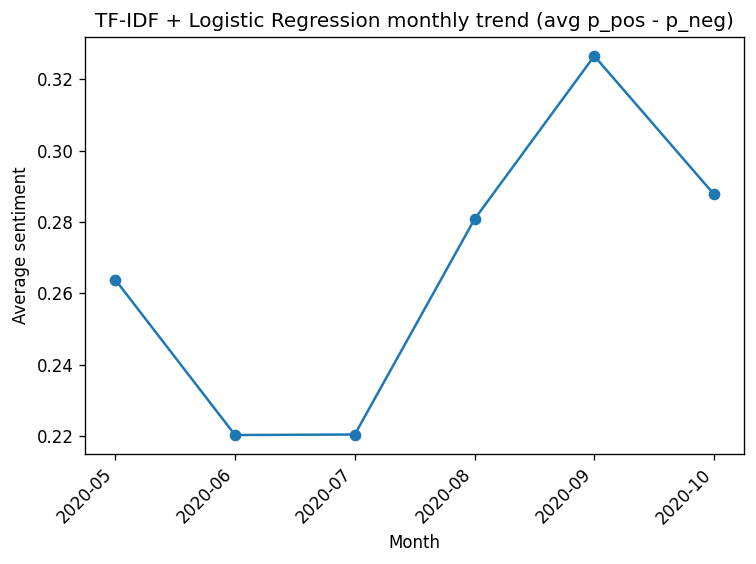

In [17]:
df["month"] = df["time"].dt.to_period("M").astype(str)

lr_trend = (
    df.groupby("month")
      .agg(avg_sent=("lr_sent_score_prob","mean"), n=("tweet_id","size"))
      .reset_index()
)

display(lr_trend)

plt.plot(lr_trend["month"], lr_trend["avg_sent"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("TF-IDF + Logistic Regression monthly trend (avg p_pos - p_neg)")
plt.xlabel("Month")
plt.ylabel("Average sentiment")
plt.tight_layout()
plt.show()


### Engagement relationship

In [20]:
for col in ["likes","retweets","replies"]:
    df[f"log_{col}"] = np.log1p(df[col])

corr_likes = np.corrcoef(df["lr_sent_score_prob"], df["log_likes"])[0,1]
corr_rts   = np.corrcoef(df["lr_sent_score_prob"], df["log_retweets"])[0,1]
corr_rep   = np.corrcoef(df["lr_sent_score_prob"], df["log_replies"])[0,1]

print("corr(LR, log_likes)   =", round(corr_likes, 4))
print("corr(LR, log_retweets)=", round(corr_rts, 4))
print("corr(LR, log_replies) =", round(corr_rep, 4))


corr(LR, log_likes)   = 0.0653
corr(LR, log_retweets)= -0.0071
corr(LR, log_replies) = 0.0175


### Save output

In [21]:
OUT_PATH = "/Users/majid/Documents/3-third semester/text mining /senator_tweets_with_lr_tfidf.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)


Saved: /Users/majid/Documents/3-third semester/text mining /senator_tweets_with_lr_tfidf.csv


# Answers to RQs (based on TF-IDF + LR results)

### RQ1: How does sentiment differ by party?

Republican tweets are **more positive** than Democratic tweets. Republicans have higher average sentiment (0.369 vs 0.191), higher positive rate (46.5% vs 35.9%), and lower negative rate (6.5% vs 13.8%).

### RQ2: Does sentiment shift over time?

Yes. Sentiment is lower in June/July, then increases in August and peaks in September, with a small decline in October.

### RQ3: Is sentiment associated with engagement?

Only weakly. Sentiment has a small positive correlation with likes, and almost zero correlation with retweets and replies. Engagement is probably influenced more by topic and account popularity.

---

> Because the senators dataset has no gold sentiment labels, TF-IDF+LR was trained using Transformer pseudo-labels; therefore, the evaluation metrics measure agreement with the Transformer model rather than true human sentiment accuracy.


## Comparison of methods (overall)

In my project I used three sentiment approaches:

1. **Transformer (RoBERTa Twitter model)** – context-aware, gives probabilities for Negative/Neutral/Positive.
2. **VADER (dictionary / rule-based)** – counts sentiment words and rules, simple baseline.
3. **TF-IDF + Logistic Regression (supervised + tuned)** – classical ML model trained with pseudo-labels.

Even though the numbers are not identical, all methods show the **same main story**: **Republican tweets are more positive on average than Democratic tweets**, and sentiment is highest around **September**.


### Comparison table (Transformer vs VADER vs TF-IDF+LogReg)

| Method                           | Type                                                           | Labels distribution (overall)                                             | Party avg sentiment (Rep vs Dem) | Party pos rate (Rep vs Dem) | Party neg rate (Rep vs Dem) | Monthly pattern                                                 | Engagement relationship                                 |
| -------------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------- | -------------------------------- | --------------------------- | --------------------------- | --------------------------------------------------------------- | ------------------------------------------------------- |
| **Transformer (RoBERTa)**        | Supervised Transformer (pretrained)                            | Neutral highest; Positive second; Negative lowest                         | **0.399 vs 0.234**               | **0.465 vs 0.357**          | **0.063 vs 0.131**          | Lowest around **July**, peak **September**, slight drop October | weak: likes **0.074**, RT **0.001**, replies **0.028**  |
| **VADER**                        | Dictionary / rule-based                                        | Positive very high (19,632); Neutral 6,082; Negative 4,776                | **0.368 vs 0.298**               | **0.674 vs 0.622**          | **0.129 vs 0.176**          | More stable; peak **September**                                 | weak: likes **0.057**, RT **0.015**, replies **0.026**  |
| **TF-IDF + Logistic Regression + Grid search** | Supervised ML (tuned) *(trained on Transformer pseudo-labels)* | same as training labels (Neutral 15,058; Positive 12,196; Negative 3,106) | **0.369 vs 0.191**               | **0.465 vs 0.359**          | **0.065 vs 0.138**          | Low **June/July**, peak **September**, drop October             | weak: likes **0.065**, RT **−0.007**, replies **0.018** |


### Important to note:
> “TF-IDF + Logistic Regression was trained using Transformer pseudo-labels, so its evaluation shows agreement with the Transformer model rather than true human sentiment accuracy.”




## Short conclusion 

>Overall, **Transformer and TF-IDF+LR are more consistent with each other**, because LR was trained using Transformer pseudo-labels. **VADER gives more Positive sentiment**, which is expected since it is lexicon-based and less context-aware. Despite these differences, all methods support the same main findings: Republicans tweets are more positive than Democrats, sentiment peaks in September, and engagement has only weak connection with sentiment.